In [11]:
using LinearAlgebra
using Plots
using Distributions
using Statistics
using DataFrames
using Images
using Interpolations

# Método de Euler
function MetEuler(f, y0, t0, tn, h)
    # f: función que define la EDO dy/dt = f(t, y)
    # y0: condición inicial
    # t0: tiempo inicial
    # tn: tiempo final
    # h: tamaño del paso
    # p: parámetros de la función f

    # Número de pasos
    n_steps = Int((tn - t0) / h)
    
    t_values = zeros(n_steps + 1)
    y_values = zeros(n_steps + 1)

    # Acondiciones iniciales
    t_values[1] = t0
    y_values[1] = y0

    # Método de Euler
    for i in 1:n_steps
        t_values[i + 1] = t_values[i] + h
        y_values[i + 1] = y_values[i] + h * f(t_values[i], y_values[i])
    end

    return t_values, y_values
end

MetEuler (generic function with 2 methods)

# Modelo juguete de tomate

En este cuaderno se considera un modelo básico para el modelamiento del crecimiento del tomate. El modelo se toma como un sistema dinámico que avanza a lo largo del tiempo siguiendo ciertas reglas y con cierto conjunto de valores iniciales. El modelo consta de varias etapas:

$$\textup{Entradas} \to \textup{Procesamiento} \to \textup {Salidas}$$

- Como entradas del modelo vamos a considerar la temperatura, la concentración de dióxido de carbono y el flujo de fotones.
- En el procesamiento del modelo se planteará la siguiente ecuación diferencial ordinaria:

$$\frac{dy}{dt} = F(T,CO_{2},P)\cdot y, \quad y(t_{0}) = y_{0}$$

en donde la variable de estado del sistema se encuentra representada por $y$, $t$ es el tiempo, $(t_0,y_0)$ es el punto inicial y $F$ es una función que depende de los parámetros (e implícitamente del tiempo). El modelo supone que la tasa de cambio $\frac{dy}{dt}$ es proporcional a $y$ y que esta afectada de alguna manera por la interacción de los parámetros climáticos externos.

- En las salidas del modelo se espera tener el comportamiento de la variable de estado a lo largo del tiempo.

Se crean los datos de entrada:

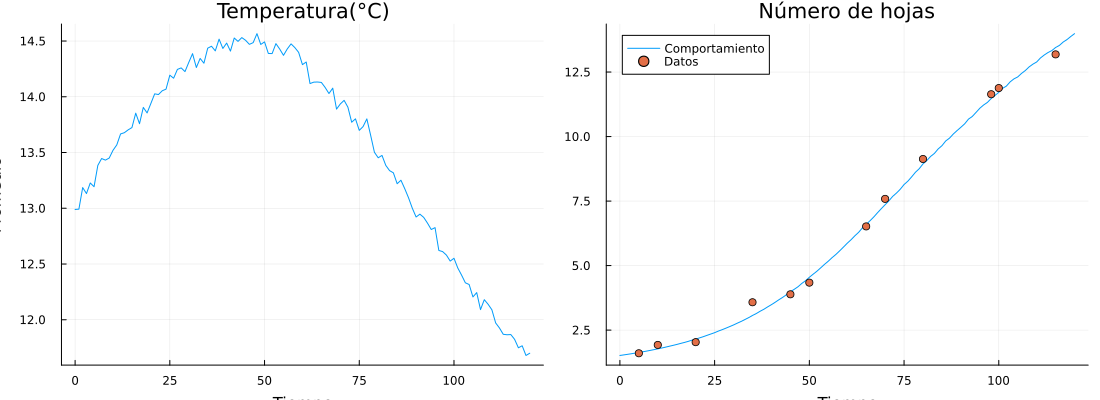

In [2]:
function T0(t) #t en días
    mean = 13 + 1.5*sin(0.035*t) + rand(Normal(0,0.05))
    max = mean + 6*rand(Uniform(0.95,1.0))
    min = mean - 6*rand(Uniform(0.95,1.0)) 
    return [min,mean,max]
end
function y(t)
    Temp_t = T0(t)
    IntT = 0.2*sum([T0(τ)[2]^6 for τ in 0:0.2:t])
    funTemp = exp(0.4144+ 285*1E-11*IntT)
    return funTemp
end
dias = [5,10,20,35,45,50,65,70,80,98,100,115]
nohojasobs = [y(t)+rand(Normal(0,0.3)) for t in dias]
py = plot(0:120,[y(t) for t in 0:120],label="Comportamiento",title="Número de hojas",xlabel="Tiempo")
py = scatter!(dias,nohojasobs,label="Datos")
plot(plot(0:120,[T0(t)[2] for t in 0:120],label="",title="Temperatura(°C)",xlabel="Tiempo",ylabel="Promedio"),py,layout=(1,2),size=(1100,400))

Supongamos que $y$ representa el número de hojas y que esta variable solo se ve afectada por el cambio de temperatura a lo largo del tiempo; de esta manera:
$$\frac{dy}{dt} = F(T(t))\cdot y(t), \quad y(t_{0}) = y_{0}$$

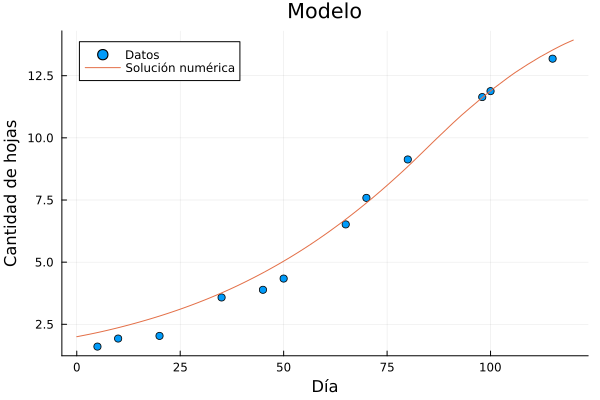

In [3]:
N = 10
Param01 = [-0.8565446935312417, 0.05932256107601765, 0.9606382699006711, -0.006998481691403796, 0.017388670039601588, 0.02371878638937072, 0.5353652547710319, -0.990316892888562, -0.20523939866792743, -0.7294790437847635]
#Param01 = Mean
#Param01 = Max_likelihood
RangoT = 0:(30)/(N-1):30
function F01(t,p)
    Temp_t = T0(t)[2]
    funTemp = interpolate((RangoT,),p, Gridded(Linear()))
    return (t,Temp_t,funTemp(Temp_t))
end

function f01(t,y,p)
    return F01(t,p)[3] * y
end

t_values, y_values = MetEuler(f01, Param01, 2, 0, 120, 0.5)
function solnum01(t)
    return interpolate((t_values,),y_values, Gridded(Linear()))(t)
end

scatter(dias,nohojasobs, label="Datos",title="Modelo", xlabel="Día", ylabel="Cantidad de hojas")
plot!(0:120,[solnum01(t) for t in 0:120],label="Solución numérica")

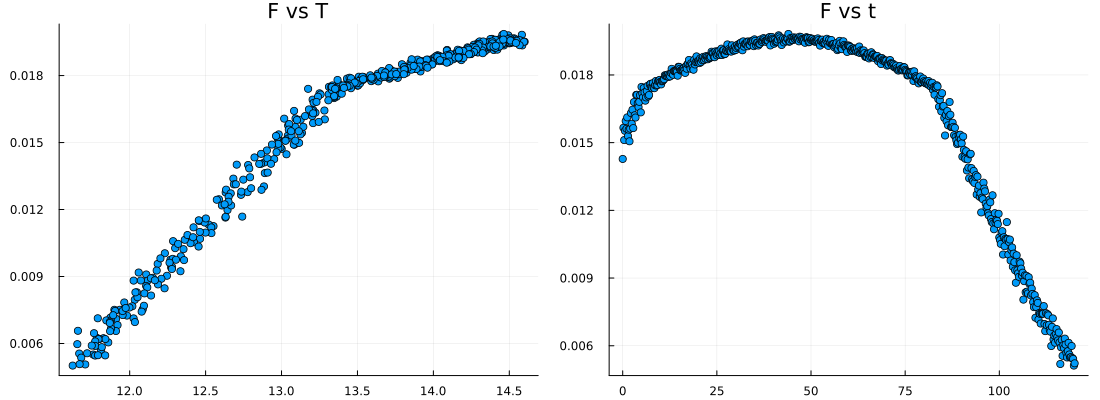

In [4]:
p1 = scatter([F01(t,Param01)[2] for t in 0:0.2:120],[F01(t,Param01)[3] for t in 0:0.2:120],label="",title="F vs T")
p2 = scatter(0:0.2:120,[F01(t,Param01)[3] for t in 0:0.2:120],label="",title="F vs t")
plot(p1,p2,layout=(1,2),size=(1100,400))

In [5]:
function energia(p)
    t_values, y_values = MetEuler(f01, p, 2, 0, 120, 0.5)
    solnum = interpolate((t_values,),y_values, Gridded(Linear())).(dias)
    
    return exp(-norm(solnum - nohojasobs)^2/norm(nohojasobs))
end
energia(0.01*ones(N))

0.0013457823269974142

In [6]:
Param001=[0.0027113044056795745, 0.025012634464276814, -0.01858878966563639, 0.01135759748357716, 0.02133277175743538, 0.0016381209094529338, -0.0006074190703868408, 0.005220451446705893, 0.04591620194237191, -0.019535751644008816]
print(energia(Param001),"\n")
for i in 1:100
    Param001random = Param001 +  rand(Normal(0,0.01),N)
    if energia(Param001random)>=energia(Param001)
        Param001 = Param001random
    end
end
print(Param001,"\n")
print(energia(Param001))

0.6954224479855907
[0.007403759678297562, 0.02169322745870874, -0.025404917445498817, -1.568590353853011e-6, 0.02218135386043785, 0.0012846590671334972, 0.006342450427290434, -0.021069428993911767, 0.060414773441813514, -0.020787275603937186]
0.7619641788281979

Ahora la idea es aproximar la función $F$ por medio de interpolación lineal de varios puntos estimados mediante inferencia bayesiana.

max_prob = 0.9208728045391412
energia(Mean) = 0.7578592851144037


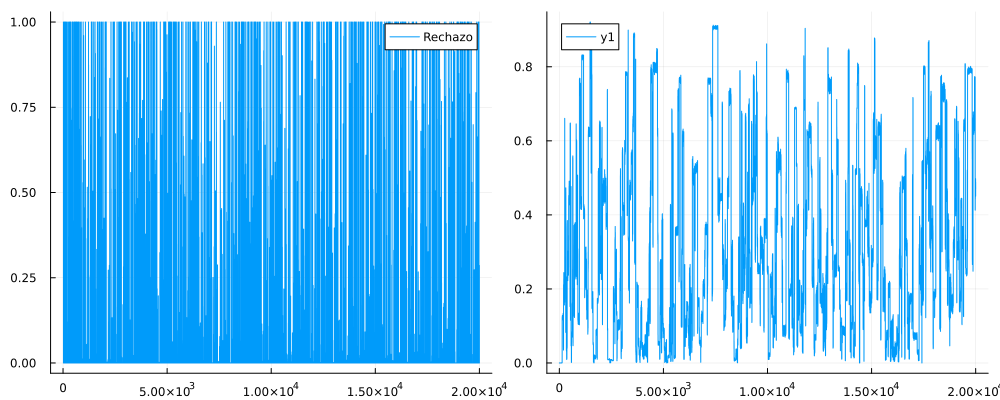

In [7]:
# Número de iteraciones
iterations = 20000
# Punto inicial donde r y K seleccionados de manera aleatoria en (0,1)
samples = [0.1*ones(N)]
probabilities = [energia(samples[end])] #Energía

Alpha = [0] # tasa de aceptación
var = 0.05 # varianza del camino aleatorio

# MHRW
for i in 1:iterations
    # Construcción de nuevas muestras con un camino aleatorio normal
    theta = samples[end]+ rand(Normal(0,var),N)

    p1 = energia(theta)
    p2 = energia(samples[end])
    alpha = min(1, p1/p2)
    
    Alpha = hcat(Alpha,alpha)
    u = rand()

    #Selección de muestras
    if u < alpha
        samples = hcat(samples, [theta])
        probabilities = hcat(probabilities,p1)
    else
        samples = hcat(samples, [samples[end]])
        probabilities = hcat(probabilities,p2)
    end
end

#Sistematic sampling
initial_position = floor(100*rand())
leap = 20
samples_ss = samples[Int(initial_position):leap:end]
probabilities_ss = probabilities[Int(initial_position):leap:end];

#Estimations
max_prob, position = findmax(probabilities)
Max_likelihood = samples[position]
Mean = mean(samples)

@show max_prob
@show energia(Mean)
#@show Max_likelihood
#@show Mean

plot(plot(Alpha[1,:],label="Rechazo"),plot(probabilities[1,:]),layout=(1,2),size=(1000,400))

In [8]:
@show Max_likelihood

Max_likelihood = [0.12956774964913859, 0.3776722699389989, -0.10436106126529465, -0.0034349273829881524, 0.015558861016250222, 0.030480541333818546, 0.4349646684540318, 1.1808631952110977, 0.1814952387895394, -0.19359901665648122]


10-element Vector{Float64}:
  0.12956774964913859
  0.3776722699389989
 -0.10436106126529465
 -0.0034349273829881524
  0.015558861016250222
  0.030480541333818546
  0.4349646684540318
  1.1808631952110977
  0.1814952387895394
 -0.19359901665648122

In [9]:
@show Mean

Mean = [-0.8570283358596661, 0.9579188170058227, 0.10613942926812597, 0.002412872910275594, 0.015434130650343015, 0.024685278910117216, -0.14860490986867347, 0.30436560266014595, 0.7676099147104117, 0.23285835954701076]


10-element Vector{Float64}:
 -0.8570283358596661
  0.9579188170058227
  0.10613942926812597
  0.002412872910275594
  0.015434130650343015
  0.024685278910117216
 -0.14860490986867347
  0.30436560266014595
  0.7676099147104117
  0.23285835954701076